In [1]:
import openpyxl
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import svm
import datetime
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

import statsmodels.api as sm

import itertools
import optuna

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima_model
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
wb1 = openpyxl.load_workbook(r"data_sheets\11111111111111.xlsx")
sheet = wb1['Отчет']

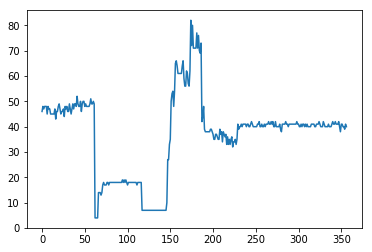

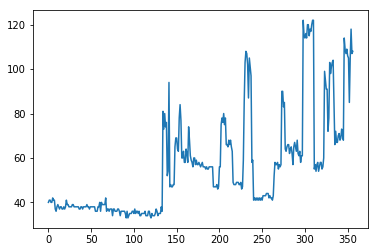

In [3]:
start = datetime.datetime.now()
timer = []
batch_train = []
batch_test = []
n = 18
border = 376
num = 734
for i in range (1, border-n):
    timer.append(sheet.cell(row = i+n, column = 1).value)
    batch_train.append(float(sheet.cell(row = i+n, column = 7).value))
for j in range (border-n, num-n-1):
    timer.append(sheet.cell(row = j+n, column = 1).value)
    batch_test.append(float(sheet.cell(row = j+n, column = 7).value))
plt.plot(batch_train)
plt.show()
plt.plot(batch_test)
plt.show()

    

In [4]:
df1 =  pd.DataFrame(columns = ["flow1"])
df1.flow1 = batch_test

model1 = SARIMAX(df1, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result1 = model1.fit()

prog_start = 0

pred1 = result1.get_prediction(start = prog_start, dynamic = False)
forecast_values1 = pred1.predicted_mean

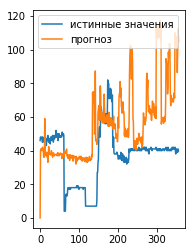

In [5]:
#forecast_mse1 = ((forecast_values1 - batch_test) ** 2).mean()
    
figure = pylab.subplot(1,2,2)
figure1 = pylab.plot(batch_train, label = "истинные значения")
figure2 = pylab.plot(forecast_values1, label = "прогноз")
pylab.legend()

In [6]:
difference = np.mean(forecast_values1 - batch_train)
forecast_mse1 = np.sqrt(((forecast_values1 - batch_train) ** 2).mean())
print(forecast_mse1, difference)

29.612383910815016 18.526874182403027


In [14]:
def params_optimization(dataset, dataset_test, seasonal, non_seasonal, cycles):
    
    model1 = SARIMAX(dataset, order=non_seasonal, seasonal_order=seasonal)
    result1 = model1.fit()
    pred1 = result1.get_prediction(0, dynamic = False)
    difference = np.mean(forecast_values1 - dataset_test)
    forecast_mse = np.sqrt(((forecast_values1 - dataset_test) ** 2).mean())
    for i in (1, cycles):
        seasonal = [x+1 for x in seasonal]
        non_seasonal = [x+1 for x in non_seasonal]
        model1 = SARIMAX(dataset, order=non_seasonal, seasonal_order=seasonal)
        result1 = model1.fit()
        pred1 = result1.get_prediction(0, dynamic = False)
        difference = np.mean(forecast_values1 - dataset_test)
        forecast_mse_temp = np.sqrt(((forecast_values1 - dataset_test) ** 2).mean())
        if (forecast_mse > forecast_mse_temp):
            forecast_mse = forecast_mse_temp
        else:
            seasonal = [x-1 for x in seasonal]
            non_seasonal = [x-1 for x in non_seasonal]
    return [difference, forecast_mse]
    

In [15]:
params_non_seasonal = [1, 1, 1]
params_seasonal = [2, 1, 1, 10]
print(params_optimization(df1, batch_test, params_seasonal, params_non_seasonal, 4))


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[-0.646795285384086, 9.212142594870441]


In [13]:
print(params_seasonal, params_non_seasonal)

[2, 1, 1, 10] [1, 1, 1]
